# Descriptive Statistics

## Setup

In [1]:
# %pip install -r ./requirements.txt

In [2]:
from datetime import date
import numpy as np

import opendatasets as od
import os
import pandas as pd
import seaborn as sns

import plotly.express as px
import matplotlib.pyplot as plt


In [3]:
def get_dataTypes_and_missingValues(df):
    info = pd.DataFrame()
    info['data_types'] =  df.dtypes
    info['unique_values'] = df.nunique()
    info['missing_values'] = df.isna().sum()
    return info

## Data Overview and Summary Statistics

In [4]:
help(od.download)

Help on function download in module opendatasets:

download(dataset_id_or_url, data_dir='.', force=False, dry_run=False, **kwargs)



In [5]:
url_path = "https://www.kaggle.com/competitions/store-sales-time-series-forecasting"
od.download(url_path, os.path.join("..","data"))

Skipping, found downloaded files in "..\data\store-sales-time-series-forecasting" (use force=True to force download)


Let us take a look at the downloaded files

In [6]:
data_dir = os.path.join("..","data","store-sales-time-series-forecasting")
print("The files contained in the data directory are: ")
for file in os.listdir(data_dir):
    print("\t",file)

The files contained in the data directory are: 
	 holidays_events.csv
	 oil.csv
	 sample_submission.csv
	 stores.csv
	 test.csv
	 train.csv
	 transactions.csv


We are interested in the training file.

In [7]:
raw_df = pd.read_csv(os.path.join(data_dir, "train.csv"))
print(f"The data contains {raw_df.shape[0]} rows and {raw_df.shape[1]} columns")

The data contains 3000888 rows and 6 columns


Inspecting the training data further

In [8]:
raw_df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


The data has a date attribute this could be an indication of it being time series. One more condition to verify that we have a time series data for this use case is that the period attribute needs to be continuous. 

In [9]:
get_dataTypes_and_missingValues(raw_df)

,data_types,unique_values,missing_values
id,int64,3000888,0
date,object,1684,0
store_nbr,int64,54,0
family,object,33,0
sales,float64,379610,0
onpromotion,int64,362,0


We have 2 observations so far:
1. The date column contains more than one date, making it continuous in this example(note slight difference from continuous and decrete data) and validating that this is a <i>Time Series Data</i>
2. The id column contains unique identifiers of each observation and can be removed.

In [10]:
raw_df.drop("id", axis=1, inplace=True)
print(f"The data contains {raw_df.shape[0]:,} rows and {raw_df.shape[1]} columns")

The data contains 3,000,888 rows and 5 columns


### Date

In [11]:
print(f"The sales data ranges from {min(raw_df['date'])} - {max(raw_df['date'])}")

The sales data ranges from 2013-01-01 - 2017-08-15


The sales data spans 4+ years and contains over 3 million observations.

Let us group the data by quarter

In [12]:
agg_sale_by_nbr = raw_df.groupby("store_nbr").agg({"sales":"sum"})

To simplify our observation we consider the data for store 1.

In [13]:
store1_raw_df = raw_df[raw_df["store_nbr"] == 1]
get_dataTypes_and_missingValues(store1_raw_df)

,data_types,unique_values,missing_values
date,object,1684,0
store_nbr,int64,1,0
family,object,33,0
sales,float64,13668,0
onpromotion,int64,155,0


We need to convert the data to the appropriate date type and we can set the date as the index

In [14]:
store1_raw_df.loc[:, "date"] = pd.to_datetime(store1_raw_df["date"])
store1_raw_df.set_index("date", inplace=True)

In [15]:
store1_raw_df

,store_nbr,family,sales,onpromotion
date,,,,
2013-01-01,1,AUTOMOTIVE,0.000000,0
2013-01-01,1,BABY CARE,0.000000,0
2013-01-01,1,BEAUTY,0.000000,0
2013-01-01,1,BEVERAGES,0.000000,0
2013-01-01,1,BOOKS,0.000000,0
...,...,...,...,...
2017-08-15,1,POULTRY,234.892000,0
2017-08-15,1,PREPARED FOODS,42.822998,0
2017-08-15,1,PRODUCE,2240.230000,7


We want to view the total sales for each quarter. To start off we aggregate the yearly sales data.

In [16]:
agg_yearly_sales = store1_raw_df['sales'].resample('Y').sum()
agg_yearly_sales

date
2013-12-31    1.894713e+06
2014-12-31    2.899710e+06
2015-12-31    3.120580e+06
2016-12-31    3.793493e+06
2017-12-31    2.436518e+06
Freq: A-DEC, Name: sales, dtype: float64

c:\Users\chiso\anaconda3\envs\ml\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\chiso\anaconda3\envs\ml\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


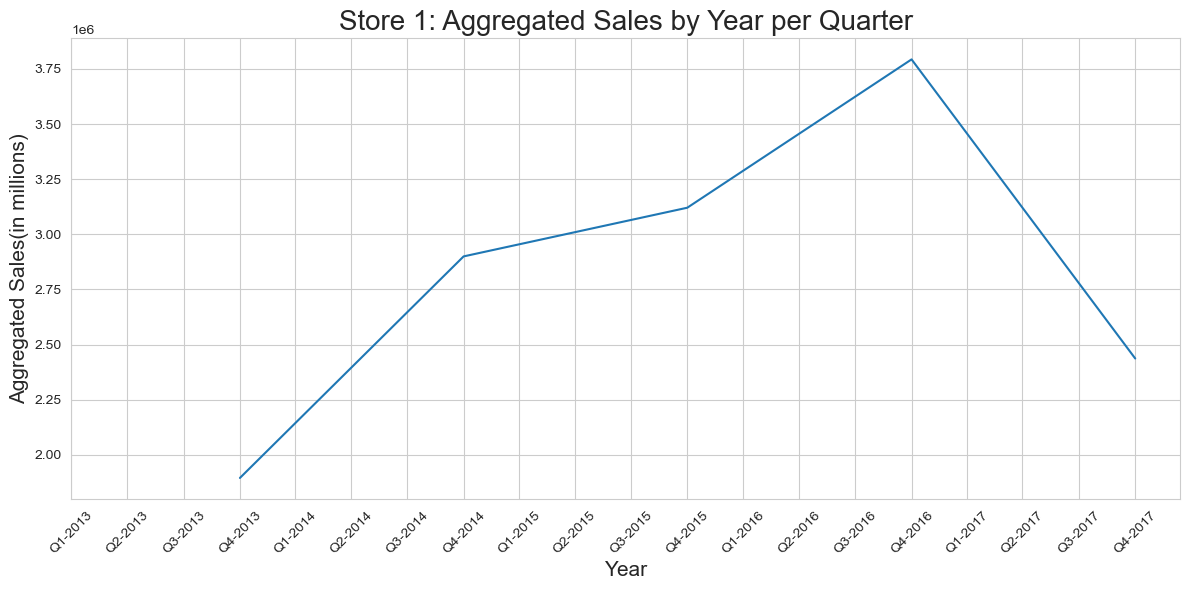

In [17]:
# Create a line plot with seaborn
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))
sns.lineplot(data=agg_yearly_sales)

# Set x-axis ticks at each quarter
quarters = pd.date_range(start=pd.Timestamp('2013-01'), end=agg_yearly_sales.index[-1], freq='Q')
plt.xticks(ticks=quarters, labels=[f"Q{1 + i%4}-{quarters[i].strftime('%Y')}" for i in range(len(quarters))], rotation=45)

# Set labels and title
plt.xlabel('Year', fontsize=15)
plt.ylabel('Aggregated Sales(in millions)', fontsize=15)
plt.title('Store 1: Aggregated Sales by Year per Quarter', fontsize=20)

# Show the plot
plt.tight_layout()
plt.show()

The data for store 1 seems to peak in the fourth quarter of 2016.

Next we reduce the granularity of the period and view data for a month, since this data spans 4 years we will look at the data for the January 2013.

In [18]:
jan_sales = store1_raw_df.loc[pd.Timestamp('2013-01'):pd.Timestamp('2013-01-31')]
agg_jan_sales = jan_sales.groupby("date").agg({"sales":"sum"})
agg_jan_sales = agg_jan_sales.replace([np.inf, -np.inf], np.nan)
agg_jan_sales

,sales
date,
2013-01-01,0.000000
2013-01-02,7417.148000
2013-01-03,5873.244001
2013-01-04,5919.879001
2013-01-05,6318.785010
2013-01-06,2199.087000
2013-01-07,6150.924000
2013-01-08,5597.181000
2013-01-09,6808.578990


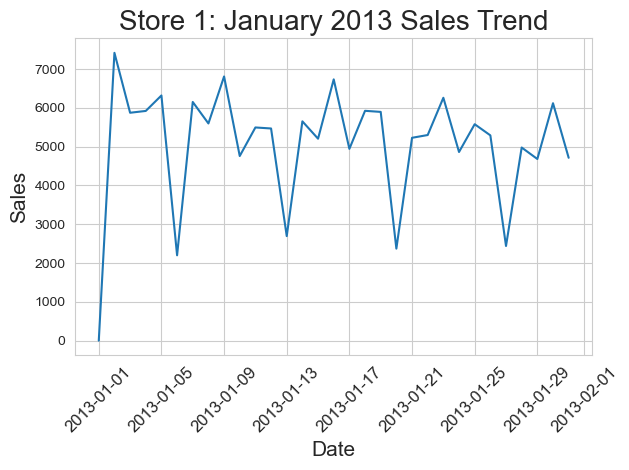

In [19]:
plt.plot(agg_jan_sales.index, agg_jan_sales["sales"])

plt.title('Store 1: January 2013 Sales Trend', fontsize=20)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Sales', fontsize=15)

plt.xticks(rotation=45, fontsize=12)
plt.tight_layout()
plt.show()

### Store Number

There are multiple stores let us take a look into the store number statistics.

In [20]:
print(f"There are exactly {raw_df['store_nbr'].nunique()} stores in the data")

There are exactly 54 stores in the data


Let us visualize the distribution of the data for each store

### Family or Item Category

In [21]:
print(f"There are exactly {raw_df['family'].nunique()} families/categories of retail products in the data")

There are exactly 33 families/categories of retail products in the data


### Sales and Promotion

In [22]:
raw_df["onpromotion"].unique()

array([  0,   3,   5,   1,  56,  20,  19,   2,   4,  18,  17,  12,   6,
         7,  10,   9,  50,   8,  16,  42,  51,  13,  15,  47,  21,  40,
        37,  54,  24,  58,  22,  59,  11,  45,  25,  55,  26,  43,  35,
        14,  28,  46,  36,  32,  53,  57,  27,  39,  41,  30,  29,  49,
        23,  48,  44,  38,  31,  52,  33,  34,  61,  60, 116,  86,  73,
       113, 102,  68, 104,  93,  70,  92, 121,  72, 178, 174, 161, 118,
       105, 172, 163, 167, 142, 154, 133, 180, 181, 173, 165, 168, 186,
       140, 149, 145, 169, 188,  62,  84, 111,  65, 107,  63, 101,  87,
       125,  94, 114, 171, 153, 170, 166, 141, 155, 179, 192, 131, 147,
       151, 189,  79,  74, 110,  64,  67,  99, 123, 157, 117, 150, 182,
       162, 160, 194, 135, 190,  69, 108,  89, 126, 156, 103, 146, 132,
       177, 164, 176, 112,  75, 109,  91, 128, 175, 187, 148, 137, 184,
       196, 144, 158, 119, 106,  66, 100,  90, 120, 115,  98, 159, 152,
       185, 139, 143,  80, 124,  71, 134, 193,  78,  88, 122, 13